<a href="https://colab.research.google.com/github/Roman-212/Kursk_Appeals_of_citizens/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BA_%D0%BE%D0%B1%D1%80%D0%B0%D1%89%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B3%D1%80%D0%B0%D0%B6%D0%B4%D0%B0%D0%BD_%E2%84%963_(%D0%9F%D1%80%D0%B5%D0%B4%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
import re
import seaborn as sns 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Загружаем фреймы
df = pd.read_csv(open('/content/drive/MyDrive/Базы/Обращения граждан/train_dataset_train.csv')) 
df_test = pd.read_csv(open('/content/drive/MyDrive/Базы/Обращения граждан/test_dataset_test.csv')) 
df.drop(df.columns[[2,3]], axis=1, inplace=True)

# **Обрабатываем обучающий датасет**

In [5]:
# Подсчет соотношения часла строк к число слов в строке
number_of_samples = len(df)
print("Количество строк (объектов)" , number_of_samples)

number_of_words = 0
for index, row in df.iterrows():
  words = row['Текст Сообщения'].split()
  number_of_words += len(words)
number_of_words_per_sample = number_of_words / len(df)
print("Количество cлов в строке" , number_of_words_per_sample)

ratio = number_of_samples / number_of_words_per_sample
print("Соотношение: " , ratio)

# Проводим выбор метода машинного обучения (модели) на основе вычисленного показателя

Количество строк (объектов) 2000
Количество cлов в строке 51.445
Соотношение:  38.8764700165225


In [7]:
from string import punctuation  # Модуль для работы со строками

# Удаление символов пунктуации
def remove_punctuation(my_string):
    return "".join([ch if ch not in punctuation else ' ' for ch in my_string]) # Замена на пробелы!!!

# Удаление чисел
def remove_numbers(my_string):
    return ''.join([i if not i.isdigit() else ' ' for i in my_string])

# Замена множественных пробелов на одинарный пробел
import re
def remove_multiple_spaces(my_string):
	return re.sub(r'\s+', ' ', my_string, flags=re.I)

# Обработка строк + дополнительно приведение к нижнему регистру
preproccessing = lambda text: (remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower())))) 

# Создаем колонку в датасете для обработанного текста
df['Текст Сообщения_2'] = list(map(preproccessing, df['Текст Сообщения']))
df.head()

,id,Текст Сообщения,Категория,Текст Сообщения_2
0,2246,Помогите начальник Льговского рэс не реагирует...,3,помогите начальник льговского рэс не реагирует...
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,3,p по фасаду дома по адресу ул урицкого проход...
2,2240,Агресивные собаки. На радуге там стая из подро...,1,агресивные собаки на радуге там стая из подрос...
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,3,p на пересечении nbsp улиц сосновская и берег...
4,1797,<p style=`text-align:justify;`><span style=`ba...,3,p style text align justify span style backgro...


## Стемминг

Сте́мминг (англ. stemming — находить происхождение) — это процесс нахождения основы слова для заданного исходного слова. Основа слова не обязательно совпадает с морфологическим корнем слова. Стемминг является частью процесса нормализации текста.

Конкретный способ решения задачи поиска основы слов называется алгоритм стемминга, а конкретная реализация — стеммер

In [15]:
# NLTK - библиотек Python для решения задач обработки естественного языка
import nltk

from nltk.stem.snowball import SnowballStemmer    # Стеммер Porter2 - новая версия стеммера Портера
from nltk.corpus import stopwords                 # Библиотека стоп-слов
from nltk import word_tokenize                    # Токенизатор

nltk.download('stopwords')                        # Загрузка стоп-слов
nltk.download('punkt')                            # Загрузка символов пунктуации
stemmer = SnowballStemmer("russian")              # Стеммер для русского языка

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
russian_stopwords = stopwords.words("russian")    # Список стоп-слов для русского языка
# Расширение списка стоп-слов (см. набор данных)
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д', 'nan'])

In [17]:
# Провердим стемминг и избавляемся от стоп-слов
stemmed_text_column = []
for text in tqdm(df['Текст Сообщения_2']):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_text_column.append(text)

# Создаем новую колонку в наборе данных
df['text_stemmed'] = stemmed_text_column
df['text_stemmed'][0]

  0%|          | 0/2000 [00:00<?, ?it/s]

'помог начальник льговск рэс реагир жалоб мал ветер сид свет имен деревн больш угон улиц стар слобод пожалуйст помог пуска вычист фотоотчет сдела'

## Лемматизация

Лемматиза́ция — процесс приведения словоформы к лемме — её нормальной (словарной) форме.

In [8]:
!pip install pymorphy2            # pymorphy2 - морфологический анализатор для русского языка
!pip install pymorphy2-dicts      # пакет со словарями
!pip install DAWG-Python 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 8.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [20]:
from tqdm.auto import tqdm, trange  # Tqdm — библиотека для создания индикаторов выполнения

# Провердим лемматизацию и избавляемся от стоп-слов
lemm_texts_column = []
for text in tqdm(df['Текст Сообщения_2']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
df['text_lemmed'] = lemm_texts_column

df['text_lemmed'][0]

  0%|          | 0/2000 [00:00<?, ?it/s]

'помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет именно деревня больший угон улица старый слобода пожалуйста помочь пускай вычистить фотоотчёт сделать'

In [22]:
df.head(5)

,id,Текст Сообщения,Категория,Текст Сообщения_2,text_stemmed,text_lemmed
0,2246,Помогите начальник Льговского рэс не реагирует...,3,помогите начальник льговского рэс не реагирует...,помог начальник льговск рэс реагир жалоб мал в...,помочь начальник льговский рэс реагировать жал...
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,3,p по фасаду дома по адресу ул урицкого проход...,p фасад дом адрес ул урицк проход труб газов м...,p фасад дом адрес ул урицкий проходить труба г...
2,2240,Агресивные собаки. На радуге там стая из подро...,1,агресивные собаки на радуге там стая из подрос...,агресивн собак радуг ста подросш щенк звросл с...,агресивный собака радуга стая подрасти щенок з...
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,3,p на пересечении nbsp улиц сосновская и берег...,p пересечен nbsp улиц сосновск берегов nbsp за...,p пересечение nbsp улица сосновский береговой ...
4,1797,<p style=`text-align:justify;`><span style=`ba...,3,p style text align justify span style backgro...,p style text align justify span style backgrou...,p style text align justify span style backgrou...


# **Нормализуем данные и обучаем НС_1**
**Для колонки "Текст обращения_2**

In [55]:
texts = df['Текст Сообщения_2'].values #Извлекаем данные всех текстов из столбца text
classes = list(df['Категория'].values) #Извлекаем соответствующие им значения классов (лейблов) столбца text
maxWordsCount = 20000 #Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['Категория'].unique()) #Выводим все уникальные значения классов
nClasses = df['Категория'].nunique()#+1  #Задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #Посмотрим на количество классов

[ 3  1 16  0  6  8  4 13 10 11 14  7  5 15  2  9 12]
17


In [56]:
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(texts) #"Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
#Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) #Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  #Посмотрим на форму текстов
print(xAll[0, :20])#И отдельно на фрагмент начала вектора
print("Размер словаря", len(tokenizer.word_index.items()))

(2000, 20000)
[0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
Размер словаря 17778


In [25]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print(encoder.classes_)
print(classesEncoded.shape)
print(classesEncoded[:17])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
(2000,)
[ 3  3  1  3  3  3  3 16  3  0  0  3  3  3  0  3  3]


In [26]:
yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 17, с 1кой в позиции соответствующего класса и нулями
print(yAll.shape) # Посмотрим на форму лейблов категорий
print(yAll[0]) # И отдельно на первую строку

(2000, 17)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle = True)
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(1600, 20000)
(1600, 17)


In [28]:
# Сохраняем сеть на каждой эпохе
# {epoch:02d} - номер эпохи
# {val_acc:.4f} - значение аккуратности на проверочном ноборе данных
callbacks = [ModelCheckpoint('save_models/Текст_сообщения_2-{epoch:02d}-{val_loss:.4f}.hdf5')]
# Сохраняем только лучший вариант сети
#callbacks = [ModelCheckpoint('save/Kursk-text.hdf5', monitor='val_loss', save_best_only=True)]

Epoch 1/30
25/25 - 2s - loss: 2.4448 - accuracy: 0.4225 - val_loss: 1.8388 - val_accuracy: 0.4850 - 2s/epoch - 71ms/step
Epoch 2/30
25/25 - 1s - loss: 1.6315 - accuracy: 0.4762 - val_loss: 1.3542 - val_accuracy: 0.5350 - 621ms/epoch - 25ms/step
Epoch 3/30
25/25 - 1s - loss: 1.1214 - accuracy: 0.6169 - val_loss: 1.0976 - val_accuracy: 0.6725 - 639ms/epoch - 26ms/step
Epoch 4/30
25/25 - 1s - loss: 0.7426 - accuracy: 0.7656 - val_loss: 0.9538 - val_accuracy: 0.7250 - 650ms/epoch - 26ms/step
Epoch 5/30
25/25 - 1s - loss: 0.4942 - accuracy: 0.8556 - val_loss: 0.9419 - val_accuracy: 0.7500 - 612ms/epoch - 24ms/step
Epoch 6/30
25/25 - 1s - loss: 0.3510 - accuracy: 0.9019 - val_loss: 0.9262 - val_accuracy: 0.7975 - 620ms/epoch - 25ms/step
Epoch 7/30
25/25 - 1s - loss: 0.2608 - accuracy: 0.9287 - val_loss: 0.9415 - val_accuracy: 0.7975 - 614ms/epoch - 25ms/step
Epoch 8/30
25/25 - 1s - loss: 0.2171 - accuracy: 0.9394 - val_loss: 1.0197 - val_accuracy: 0.8025 - 619ms/epoch - 25ms/step
Epoch 9/30


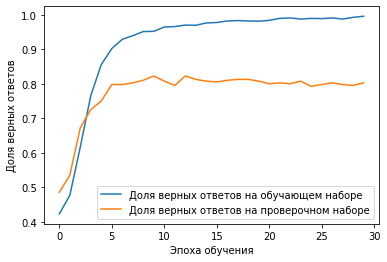

In [29]:
#Создаём полносвязную сеть
model = Sequential()
#Входной полносвязный слой
model.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.3)) 
#Второй полносвязный слой
model.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.3))
#Третий полносвязный слой
model.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.3))
#Выходной полносвязный слой
model.add(Dense(nClasses, activation='softmax'))
time_start = [time.time()]

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=64,
                    validation_data=(xVal, yVal),
                    verbose=2) # ,
                    #callbacks=callbacks01

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [30]:
model.save('/content/drive/MyDrive/Предобученные сети/Курск/Предобработка текста/Текст_сообщения_2-Vc0.8025.hdf5')

# **Нормальзуем данные и обучаем НС_2**
**Для колонки 'text_stemmed'**


In [85]:
texts_st = df['text_stemmed'].values #Извлекаем данные всех текстов из столбца text
classes_st = list(df['Категория'].values) #Извлекаем соответствующие им значения классов (лейблов) столбца text
maxWordsCount_st = 9000 #Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['Категория'].unique()) #Выводим все уникальные значения классов
nClasses_st = df['Категория'].nunique()#+1  #Задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses_st) #Посмотрим на количество классов

[ 3  1 16  0  6  8  4 13 10 11 14  7  5 15  2  9 12]
17


In [80]:
tokenizer_st = Tokenizer(num_words=maxWordsCount_st, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer_st.fit_on_texts(texts_st) #"Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
#Формируем матрицу индексов по принципу Bag of Words
xAll_st = tokenizer_st.texts_to_matrix(texts_st) #Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll_st.shape)  #Посмотрим на форму текстов
print(xAll_st[0, :20])#И отдельно на фрагмент начала вектора
print("Размер словаря", len(tokenizer_st.word_index.items()))

(2000, 9000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размер словаря 8505


In [83]:
#Преобразовываем категории в векторы
encoder_st = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder_st.fit(classes_st) # Подгружаем в него категории из нашей базы
classesEncoded_st = encoder_st.transform(classes_st) # Кодируем категории
print(encoder_st.classes_)
print(classesEncoded_st.shape)
print(classesEncoded_st[:17])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
(2000,)
[ 3  3  1  3  3  3  3 16  3  0  0  3  3  3  0  3  3]


In [86]:
yAll_st = utils.to_categorical(classesEncoded_st, nClasses_st) # И выводим каждый лейбл в виде вектора длиной 17, с 1кой в позиции соответствующего класса и нулями
print(yAll_st.shape) # Посмотрим на форму лейблов категорий
print(yAll_st[0]) # И отдельно на первую строку

(2000, 17)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [87]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain_st, xVal_st, yTrain_st, yVal_st = train_test_split(xAll_st, yAll_st, test_size=0.2, shuffle = True)
print(xTrain_st.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain_st.shape) #и на форму соответсвующих им классов

(1600, 9000)
(1600, 17)


In [89]:
# Сохраняем сеть на каждой эпохе
# {epoch:02d} - номер эпохи
# {val_acc:.4f} - значение аккуратности на проверочном ноборе данных
callbacks_st = [ModelCheckpoint('save_models_st/text_stemmed-{epoch:02d}-{val_loss:.4f}.hdf5')]
# Сохраняем только лучший вариант сети
#callbacks = [ModelCheckpoint('save/Kursk-text.hdf5', monitor='val_loss', save_best_only=True)]

Epoch 1/30
25/25 - 2s - loss: 2.4331 - accuracy: 0.3944 - val_loss: 1.7684 - val_accuracy: 0.4850 - 2s/epoch - 74ms/step
Epoch 2/30
25/25 - 1s - loss: 1.5922 - accuracy: 0.5069 - val_loss: 1.3648 - val_accuracy: 0.5550 - 772ms/epoch - 31ms/step
Epoch 3/30
25/25 - 1s - loss: 1.0891 - accuracy: 0.6300 - val_loss: 1.0955 - val_accuracy: 0.6650 - 1s/epoch - 43ms/step
Epoch 4/30
25/25 - 0s - loss: 0.7393 - accuracy: 0.7819 - val_loss: 1.0494 - val_accuracy: 0.7150 - 448ms/epoch - 18ms/step
Epoch 5/30
25/25 - 0s - loss: 0.5075 - accuracy: 0.8512 - val_loss: 0.9917 - val_accuracy: 0.7350 - 390ms/epoch - 16ms/step
Epoch 6/30
25/25 - 0s - loss: 0.3601 - accuracy: 0.9006 - val_loss: 1.0077 - val_accuracy: 0.7350 - 405ms/epoch - 16ms/step
Epoch 7/30
25/25 - 0s - loss: 0.2778 - accuracy: 0.9187 - val_loss: 1.0477 - val_accuracy: 0.7525 - 440ms/epoch - 18ms/step
Epoch 8/30
25/25 - 0s - loss: 0.2264 - accuracy: 0.9375 - val_loss: 1.0714 - val_accuracy: 0.7600 - 428ms/epoch - 17ms/step
Epoch 9/30
25/

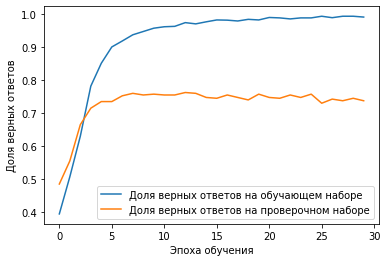

In [94]:
#Создаём полносвязную сеть
model_st = Sequential()
#Входной полносвязный слой
model_st.add(Dense(100, input_dim=maxWordsCount_st, activation="relu"))
#Слой регуляризации Dropout
model_st.add(Dropout(0.3)) 
#Второй полносвязный слой
model_st.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model_st.add(Dropout(0.3))
#Третий полносвязный слой
model_st.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model_st.add(Dropout(0.3))
#Выходной полносвязный слой
model_st.add(Dense(nClasses_st, activation='softmax'))
time_start = [time.time()]

model_st.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model_st.fit(xTrain_st, 
                    yTrain_st, 
                    epochs=30,
                    batch_size=64,
                    validation_data=(xVal_st, yVal_st),
                    verbose=2,
                    callbacks=callbacks_st) # ,
                    #callbacks=callbacks01

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [95]:
model_st = load_model('/content/save_models_st/text_stemmed-08-1.0714.hdf5')
model_st.save('/content/drive/MyDrive/Предобученные сети/Курск/Предобработка текста/text_stemmed-V_ac_0.7600.hdf5')

# **Нормальзуем данные и обучаем НС_3**
**Для колонки 'text_lemmed'**


In [98]:
texts_le = df['text_lemmed'].values #Извлекаем данные всех текстов из столбца text
classes_le = list(df['Категория'].values) #Извлекаем соответствующие им значения классов (лейблов) столбца text
maxWordsCount_le = 9000 #Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['Категория'].unique()) #Выводим все уникальные значения классов
nClasses_le = df['Категория'].nunique()#+1  #Задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses_le) #Посмотрим на количество классов

[ 3  1 16  0  6  8  4 13 10 11 14  7  5 15  2  9 12]
17


In [99]:
tokenizer_le = Tokenizer(num_words=maxWordsCount_le, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer_le.fit_on_texts(texts_le) #"Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
#Формируем матрицу индексов по принципу Bag of Words
xAll_le = tokenizer_le.texts_to_matrix(texts_le) #Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll_le.shape)  #Посмотрим на форму текстов
print(xAll_le[0, :20])#И отдельно на фрагмент начала вектора
print("Размер словаря", len(tokenizer_le.word_index.items()))

(2000, 9000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размер словаря 8674


In [100]:
#Преобразовываем категории в векторы
encoder_le = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder_le.fit(classes_le) # Подгружаем в него категории из нашей базы
classesEncoded_le = encoder_le.transform(classes_le) # Кодируем категории
print(encoder_le.classes_)
print(classesEncoded_le.shape)
print(classesEncoded_le[:17])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
(2000,)
[ 3  3  1  3  3  3  3 16  3  0  0  3  3  3  0  3  3]


In [101]:
yAll_le = utils.to_categorical(classesEncoded_le, nClasses_le) # И выводим каждый лейбл в виде вектора длиной 17, с 1кой в позиции соответствующего класса и нулями
print(yAll_le.shape) # Посмотрим на форму лейблов категорий
print(yAll_le[0]) # И отдельно на первую строку

(2000, 17)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [102]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain_le, xVal_le, yTrain_le, yVal_le = train_test_split(xAll_le, yAll_le, test_size=0.2, shuffle = True)
print(xTrain_le.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain_le.shape) #и на форму соответсвующих им классов

(1600, 9000)
(1600, 17)


In [103]:
# Сохраняем сеть на каждой эпохе
# {epoch:02d} - номер эпохи
# {val_acc:.4f} - значение аккуратности на проверочном ноборе данных
callbacks_le = [ModelCheckpoint('save_models/text_lemmed-{epoch:02d}-{val_loss:.4f}.hdf5')]
# Сохраняем только лучший вариант сети
#callbacks = [ModelCheckpoint('save/Kursk-text.hdf5', monitor='val_loss', save_best_only=True)]

Epoch 1/30
25/25 - 2s - loss: 2.4596 - accuracy: 0.3875 - val_loss: 1.8458 - val_accuracy: 0.4825 - 2s/epoch - 89ms/step
Epoch 2/30
25/25 - 1s - loss: 1.6133 - accuracy: 0.4819 - val_loss: 1.3193 - val_accuracy: 0.5350 - 768ms/epoch - 31ms/step
Epoch 3/30
25/25 - 1s - loss: 1.0981 - accuracy: 0.6463 - val_loss: 1.0045 - val_accuracy: 0.7025 - 685ms/epoch - 27ms/step
Epoch 4/30
25/25 - 1s - loss: 0.7384 - accuracy: 0.7688 - val_loss: 0.9110 - val_accuracy: 0.7250 - 629ms/epoch - 25ms/step
Epoch 5/30
25/25 - 0s - loss: 0.4974 - accuracy: 0.8431 - val_loss: 0.8669 - val_accuracy: 0.7925 - 437ms/epoch - 17ms/step
Epoch 6/30
25/25 - 0s - loss: 0.3382 - accuracy: 0.9062 - val_loss: 0.9414 - val_accuracy: 0.7950 - 489ms/epoch - 20ms/step
Epoch 7/30
25/25 - 0s - loss: 0.2567 - accuracy: 0.9256 - val_loss: 0.9784 - val_accuracy: 0.7975 - 403ms/epoch - 16ms/step
Epoch 8/30
25/25 - 0s - loss: 0.2073 - accuracy: 0.9388 - val_loss: 1.0032 - val_accuracy: 0.7900 - 426ms/epoch - 17ms/step
Epoch 9/30


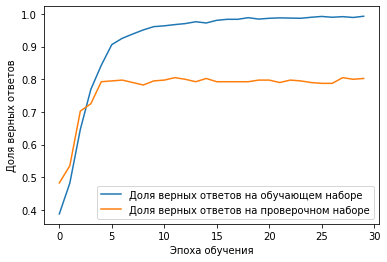

In [105]:
#Создаём полносвязную сеть
model_le = Sequential()
#Входной полносвязный слой
model_le.add(Dense(100, input_dim=maxWordsCount_le, activation="relu"))
#Слой регуляризации Dropout
model_le.add(Dropout(0.3)) 
#Второй полносвязный слой
model_le.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model_le.add(Dropout(0.3))
#Третий полносвязный слой
model_le.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model_le.add(Dropout(0.3))
#Выходной полносвязный слой
model_le.add(Dense(nClasses_le, activation='softmax'))
time_start = [time.time()]

model_le.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model_le.fit(xTrain_le, 
                    yTrain_le, 
                    epochs=30,
                    batch_size=64,
                    validation_data=(xVal_le, yVal_le),
                    verbose=2,
                     callbacks=callbacks_le) # ,
                    #callbacks=callbacks01

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [106]:
model_le = load_model('/content/save_models/text_lemmed-28-1.8024.hdf5')
model_le.save('/content/drive/MyDrive/Предобученные сети/Курск/Предобработка текста/text_lemmed-V_ac_0.8050.hdf5')

# **Обучим НС на проверочной выборке по колонке text_lemmed в 0,01%**

In [135]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain_le, xVal_le, yTrain_le, yVal_le = train_test_split(xAll_le, yAll_le, test_size=0.01, shuffle = True)
print(xTrain_le.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain_le.shape) #и на форму соответсвующих им классов

(1980, 9000)
(1980, 17)


In [133]:
# Сохраняем сеть на каждой эпохе
# {epoch:02d} - номер эпохи
# {val_acc:.4f} - значение аккуратности на проверочном ноборе данных
callbacks_le_2 = [ModelCheckpoint('save_models_le_2/text_lemmed-{epoch:02d}-{val_loss:.4f}.hdf5')]
# Сохраняем только лучший вариант сети
#callbacks = [ModelCheckpoint('save/Kursk-text.hdf5', monitor='val_loss', save_best_only=True)]

Epoch 1/30
31/31 - 1s - loss: 2.3226 - accuracy: 0.4273 - val_loss: 1.6731 - val_accuracy: 0.6000 - 1s/epoch - 35ms/step
Epoch 2/30
31/31 - 0s - loss: 1.4428 - accuracy: 0.5298 - val_loss: 1.0420 - val_accuracy: 0.6500 - 445ms/epoch - 14ms/step
Epoch 3/30
31/31 - 0s - loss: 0.9416 - accuracy: 0.6944 - val_loss: 0.7896 - val_accuracy: 0.7500 - 425ms/epoch - 14ms/step
Epoch 4/30
31/31 - 0s - loss: 0.5834 - accuracy: 0.8258 - val_loss: 0.5296 - val_accuracy: 0.9000 - 419ms/epoch - 14ms/step
Epoch 5/30
31/31 - 0s - loss: 0.3925 - accuracy: 0.8899 - val_loss: 0.5186 - val_accuracy: 0.8000 - 476ms/epoch - 15ms/step
Epoch 6/30
31/31 - 0s - loss: 0.2832 - accuracy: 0.9167 - val_loss: 0.5311 - val_accuracy: 0.8500 - 430ms/epoch - 14ms/step
Epoch 7/30
31/31 - 0s - loss: 0.2204 - accuracy: 0.9389 - val_loss: 0.5522 - val_accuracy: 0.8500 - 448ms/epoch - 14ms/step
Epoch 8/30
31/31 - 0s - loss: 0.1834 - accuracy: 0.9470 - val_loss: 0.7124 - val_accuracy: 0.8500 - 435ms/epoch - 14ms/step
Epoch 9/30


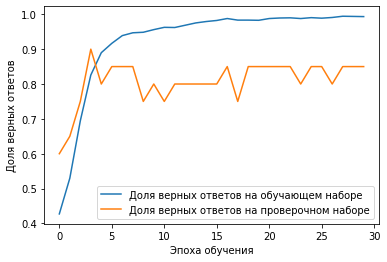

In [134]:
#Создаём полносвязную сеть
model_le_2 = Sequential()
#Входной полносвязный слой
model_le_2.add(Dense(100, input_dim=maxWordsCount_le, activation="relu"))
#Слой регуляризации Dropout
model_le_2.add(Dropout(0.3)) 
#Второй полносвязный слой
model_le_2.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model_le_2.add(Dropout(0.3))
#Третий полносвязный слой
model_le_2.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model_le_2.add(Dropout(0.3))
#Выходной полносвязный слой
model_le_2.add(Dense(nClasses_le, activation='softmax'))
time_start = [time.time()]

model_le_2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model_le_2.fit(xTrain_le, 
                    yTrain_le, 
                    epochs=30,
                    batch_size=64,
                    validation_data=(xVal_le, yVal_le),
                    verbose=2,
                     callbacks=callbacks_le_2) # ,
                    #callbacks=callbacks01

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [136]:
model_le_2 = load_model('/content/save_models_le_2/text_lemmed-05-0.5186.hdf5')
model_le_2.save('/content/drive/MyDrive/Предобученные сети/Курск/Предобработка текста/text_lemmed_2-V_ac_0.9000.hdf5')

# **Обрабатываем тестовый датасет**
**под модель model_le обученную на обработанном Лемматизированом тексте**

In [140]:
df_test = pd.read_csv(open('/content/drive/MyDrive/Базы/Обращения граждан/test_dataset_test.csv'))

# Подсчет соотношения часла строк к число слов в строке
number_of_samples = len(df_test)
print("Количество строк (объектов)" , number_of_samples)

number_of_words_test = 0
for index, row in df.iterrows():
  words = row['Текст Сообщения'].split()
  number_of_words += len(words)
number_of_words_per_sample = number_of_words / len(df_test)
print("Количество cлов в строке" , number_of_words_per_sample)

ratio = number_of_samples / number_of_words_per_sample
print("Соотношение: " , ratio)

Количество строк (объектов) 1000
Количество cлов в строке 514.45
Соотношение:  1.9438235008261249


In [141]:
from string import punctuation  # Модуль для работы со строками

# Удаление символов пунктуации
def remove_punctuation(my_string):
    return "".join([ch if ch not in punctuation else ' ' for ch in my_string]) # Замена на пробелы!!!

# Удаление чисел
def remove_numbers(my_string):
    return ''.join([i if not i.isdigit() else ' ' for i in my_string])

# Замена множественных пробелов на одинарный пробел
import re
def remove_multiple_spaces(my_string):
	return re.sub(r'\s+', ' ', my_string, flags=re.I)

# Обработка строк + дополнительно приведение к нижнему регистру
preproccessing = lambda text: (remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower())))) 

# Создаем колонку в датасете для обработанного текста
df_test['Текст Сообщения_2'] = list(map(preproccessing, df_test['Текст Сообщения']))
df_test.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Текст Сообщения_2
0,843,<p>Здравствуйте. На улице Мира &nbsp;было заме...,Неработающее наружное освещение,Администрация Курчатовского района,p здравствуйте на улице мира nbsp было замене...
1,1422,<p>Уже вторую неделю не горит уличное освещени...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...,p уже вторую неделю не горит уличное освещени...
2,2782,Не работает освещение во дворе дома 11а по Эне...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...,не работает освещение во дворе дома а по энерг...
3,2704,После покоса сорной растительности на газоне м...,Неудовлетворительная уборка улиц и тротуаров,Администрация Центрального округа города Курска,после покоса сорной растительности на газоне м...
4,1,<p>Прошу принять меры к водителю маршрута 263:...,Неудовлетворительный внешний вид (поведение) в...,Администрация города Курска,p прошу принять меры к водителю маршрута пос ...


In [142]:
# Провердим стемминг и избавляемся от стоп-слов
stemmed_text_column = []
for text in tqdm(df_test['Текст Сообщения_2']):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_text_column.append(text)

# Создаем новую колонку в наборе данных
df_test['text_stemmed'] = stemmed_text_column
df_test['text_stemmed'][0]

  0%|          | 0/1000 [00:00<?, ?it/s]

'p здравств улиц мир nbsp замен наружн освещен имен замен ламп nbsp энергосберега ламп протяжен нескольк месяц освещен улиц отсутств последн улиц освещ эт зим приблизительн кажд ден люд работа часов смен мног возвраща очен поздн дан проблем улиц поселк nbsp p'

In [143]:
from tqdm.auto import tqdm, trange  # Tqdm — библиотека для создания индикаторов выполнения

# Провердим лемматизацию и избавляемся от стоп-слов
lemm_texts_column = []
for text in tqdm(df_test['Текст Сообщения_2']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
df_test['text_lemmed'] = lemm_texts_column

df_test['text_lemmed'][0]

  0%|          | 0/1000 [00:00<?, ?it/s]

'p здравствуйте улица мир nbsp заменить наружное освещение именно заменить лампа nbsp энергосберегающий лампа протяжение несколько месяц освещение улица отсутствовать последний улица осветить это зима приблизительно каждый день человек работать часовой смена многие возвращаться очень поздно дать проблема улица посёлок nbsp p'

In [144]:
df_test.drop(df_test.columns[[1,2,3,4,5]], axis=1, inplace=True)
df_test.head(5)

,id,text_lemmed
0,843,p здравствуйте улица мир nbsp заменить наружно...
1,1422,p второй неделя гореть уличный освещение p p n...
2,2782,работать освещение двор дом энергетик световой...
3,2704,покос сорный растительность газон тротуар прое...
4,1,p просить принять мера водитель маршрут пос се...


In [145]:
#model = load_model('/content/drive/MyDrive/Предобученные сети/Курск/Предобработка текста/Текст_сообщения_2-Vc0.8025.hdf5')
model_le_2 = load_model('/content/drive/MyDrive/Предобученные сети/Курск/Предобработка текста/text_lemmed_2-V_ac_0.9000.hdf5')
test_mess = np.array(df_test['text_lemmed']) # Переводим сообщения в массив
x = tokenizer_le.texts_to_matrix(test_mess) # Токенизируем массив

prediction = model_le_2.predict(x)

for i in range(len(x)): 
  df_test.loc[i,'Категория'] = np.argmax(prediction[i])
#df_test = df_test.replace({'Категория':{0:3,1:20}})
df_test

,id,text_lemmed,Категория
0,843,p здравствуйте улица мир nbsp заменить наружно...,3.0
1,1422,p второй неделя гореть уличный освещение p p n...,3.0
2,2782,работать освещение двор дом энергетик световой...,3.0
3,2704,покос сорный растительность газон тротуар прое...,3.0
4,1,p просить принять мера водитель маршрут пос се...,8.0
...,...,...,...
995,2619,добрый день семья житель пос волокно просыпать...,0.0
996,2518,лазарев г щигры ветка тополь скоро выбить стек...,3.0
997,2524,вход комитет образование курск ям дорога,0.0
998,1577,p добрый время сутки p p пол год медотвод вакц...,4.0


In [146]:
df_test.drop(df_test.columns[[1]], axis=1, inplace=True)

In [147]:
df_test

,id,Категория
0,843,3.0
1,1422,3.0
2,2782,3.0
3,2704,3.0
4,1,8.0
...,...,...
995,2619,0.0
996,2518,3.0
997,2524,0.0
998,1577,4.0


In [148]:
df_test = df_test.astype({'Категория':'Int64'})

In [149]:
df_test.to_csv('/content/drive/MyDrive/Предобученные сети/Курск/Предобработка текста/df_messenge_lemmed_2.csv', index=False)

**Итог: на сайте показало Score = 0.651588**

In [ ]:
model1 = load_model('/content/drive/MyDrive/Предобученные сети/Курск/Предобработка текста/Текст_сообщения_2-Vc0.8025.hdf5')
test_mess = np.array(df_test['Текст Сообщения_2']) # Переводим сообщения в массив
x = tokenizer.texts_to_matrix(test_mess) # Токенизируем массив

prediction = model.predict(x)

for i in range(len(x)): 
  df_test.loc[i,'Категория'] = np.argmax(prediction[i])
#df_test = df_test.replace({'Категория':{0:3,1:20}})
df_test